# Projet RCP 209 : prédiction de rendement de stock

## Import library

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Accuracy function

In [52]:
def CFM_metrics(y_true, y_pred):
    """
    Return the metrics used for the CFM Data Challenge 2019.

    This metrics is simply the accuracy of the prediction of positive returns
    (see below for details), but based on true *returns* (y_true) and
    probabilities (of returns being positive).

    Args
        y_true: Pandas Dataframe
            target returns. Positive returns will give True, and negative ones False.

        y_pred: Pandas Dataframe
            predicted probability of positive returns.

    """
    return ((y_true.values > 0) == (y_pred.values > 0.5)).mean()

# Get data

In [53]:
data_test = pd.read_csv("data_stock\\test_input.csv", sep=',')
data_train = pd.read_csv("data_stock\\training_input.csv", sep=',')
output_train = pd.read_csv("data_stock\\training_output.csv", sep=',')

# Clean the data

In [54]:
data_train.head()

,ID,eqt_code,date,09:30:00,09:35:00,09:40:00,09:45:00,09:50:00,09:55:00,10:00:00,...,14:35:00,14:40:00,14:45:00,14:50:00,14:55:00,15:00:00,15:05:00,15:10:00,15:15:00,15:20:00
0,0,975514820,2059277756,0.378421,0.062977,-1.699955,-0.253532,0.317230,-1.394081,-1.338014,...,-0.258339,-0.193950,0.129398,0.064666,0.323250,0.193705,0.387117,0.257687,0.064357,-0.193022
1,1,975514820,661006643,-0.588441,-0.393182,0.918810,0.392393,0.195901,-0.195754,0.000000,...,0.000000,-0.260940,0.000000,-0.130601,0.130666,0.130601,0.130536,0.521881,0.260419,0.910557
2,2,975514820,2252275018,-0.974472,1.789703,-0.105310,-0.456042,0.894337,-0.341168,-0.373679,...,-0.331103,-0.236124,-0.256959,-0.229774,0.063974,-0.570371,0.133774,-0.123741,-0.764930,0.230346
3,3,975514820,901241465,-4.612982,1.746131,1.092367,-0.030626,0.996415,-1.391209,0.169799,...,0.336335,-0.185523,0.521719,-0.095356,-0.207925,0.318842,0.119798,-0.155044,0.290896,-0.058833
4,4,975514820,1213815424,-2.642804,-0.772708,-0.115318,0.145272,-0.136105,0.450894,-0.046230,...,0.631221,0.090185,-0.169416,-0.081212,-0.275152,-0.249646,0.042280,0.483204,0.394914,-0.619209


In [55]:
data_train.shape, data_test.shape, output_train.shape

((745327, 74), (319769, 74), (745327, 2))

In [56]:
data_train[["eqt_code","date"]].nunique()

eqt_code     680
date        1511
dtype: int64

# Premiere analyse

In [57]:
nb_donnee = data_train.iloc[:,3:].size
nb_nan = data_train.iloc[:,3:].isna().sum().sum()
nb_donnee,nb_nan,nb_nan/nb_donnee * 100

(52918217, 347646, 0.6569495718270326)

In [146]:
#we linearly interpolate the NaN for the volatility and extrapolate to 0 
data_train.iloc[:,3:57] = data_train.iloc[:,3:].interpolate(axis=1)
data_test.iloc[:,3:57]  = data_test.iloc[:,3:].interpolate(axis=1)
#we use a flat extrapolation
data_train.fillna(0,inplace=True)
data_test.fillna(0,inplace=True)

In [147]:
#check if there is some NaN
#NAs = pd.concat([data_train.isnull().sum(), data_test.isnull().sum()], axis=1, keys=['Train', 'Test'])
#NAs[NAs.sum(axis=1) > 0]

In [148]:
#drop not necessary data
data_train_clean = data_train.drop(['ID', 'eqt_code', 'date'], axis=1, inplace=False)
data_test_clean = data_test.drop(['ID', 'eqt_code', 'date'], axis=1, inplace=False)
y_train = output_train["end_of_day_return"].values
X_train,X_test,y_train,y_test = train_test_split(data_train_clean,y_train,test_size=.2)

# Linear regression

In [161]:
def trainData(model,train_set=X_train,test_set=X_test,output_train=y_train,output_test=y_test,pred=data_test_clean):
    print("we train on test")
    model.fit(train_set,output_train)
    print("training done, we start the prediction")
    pred_train = model.predict(train_set)
    pred_test = model.predict(test_set)
    print('Train error =', round(CFM_metrics(pd.DataFrame(data=pred_train), pd.DataFrame(data=output_train)), 4), '%')
    print('Test error =', round(CFM_metrics(pd.DataFrame(data=pred_test), pd.DataFrame(data=output_test)), 4), '%')
    print("we return the test prediction")
    return model.predict(pred)

def sendPredictionToCfmFormat(prediction, test = data_test, fileName = 'predictions'):
    output = pd.DataFrame()
    output["ID"] = test["ID"]
    output["end_of_day_return"] = prediction
    output.to_csv(fileName+'.csv', sep=',', index=False)
    print("prediction send to"+fileName+'.csv')
    
def compare(y1,y2):
    delta = y1 * y2
    return CFM_metrics(pd.DataFrame(y1), pd.DataFrame(y2)), np.sum(delta >=0)/len(y1)*100

In [150]:
from sklearn.linear_model import LinearRegression
regrLinWeighted = LinearRegression()
y_pred_linearReg = trainData(regrLinWeighted)

we train on test
training done, we start the prediction
Train error = 0.5144 %
Test error = 0.5127 %
we return the test prediction


In [151]:
sendPredictionToCfmFormat(y_pred_linearReg,fileName='predictionLinReg')

prediction send topredictionLinReg.csv


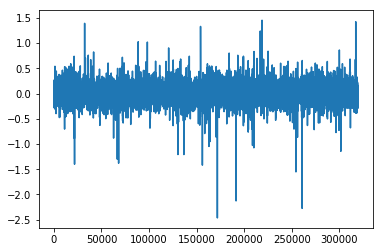

In [152]:
plt.plot(y_pred_linearReg)

## Regression with regularization : Lasso

In [153]:
from sklearn.linear_model import Lasso
lasso = Lasso(alpha=.5)
y_pred_linearRegLasso = trainData(lasso)

we train on test
training done, we start the prediction
Train error = 0.2607 %
Test error = 0.2618 %
we return the test prediction


In [154]:
sendPredictionToCfmFormat(y_pred_linearRegLasso,fileName='predictionLinLasso')

prediction send topredictionLinLasso.csv


In [155]:
compare(y_pred_linearRegLasso, y_pred_linearReg)

(0.0002533078566089896, 50.12837391992344)

## Regression with regularisation : Ridge

In [156]:
from sklearn.linear_model import Ridge
ridge = Ridge(alpha=2.0)
y_pred_linearRegRidge = trainData(ridge)

we train on test
training done, we start the prediction
Train error = 0.5144 %
Test error = 0.5127 %
we return the test prediction


In [157]:
sendPredictionToCfmFormat(y_pred_linearRegRidge,fileName='predictionLinRidge')

prediction send topredictionLinRidge.csv


In [158]:
compare(y_pred_linearRegRidge, y_pred_linearReg)

(0.4989695686573745, 100.0)

# Logistic regression

In [159]:
output_logistic= pd.DataFrame()
output_logistic["ID"] = output_train["ID"]
output_logistic["end_of_day_return"] = output_train["end_of_day_return"].apply(lambda row : 1 if row > 0 else -1)
y_train = output_logistic["end_of_day_return"].values
X_train,X_test,y_train,y_test = train_test_split(data_train_clean,y_train,test_size=.2)

In [180]:
from sklearn.linear_model import LogisticRegression
logistic = LogisticRegression(C=0.001,solver='lbfgs')
y_pred_logistic = trainData(logistic)

we train on test
training done, we start the prediction
Train error = 0.5214 %
Test error = 0.5215 %
we return the test prediction


In [177]:
from sklearn.model_selection import GridSearchCV
param = {'C':[.001,.01,.1,.2,.5,1,2,5,10]}
model = GridSearchCV(LogisticRegression(solver='lbfgs'),param,cv=5)
model.fit(X_train,y_train)
y_pred  = model.predict(X_train)
CFM_metrics(pd.DataFrame(data=y_pred), pd.DataFrame(data=y_train))
model.best_estimator_

LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [181]:
sendPredictionToCfmFormat(y_pred_logistic,fileName='predictionLogistic')

prediction send topredictionLogistic.csv


In [182]:
compare(y_pred_logistic, y_pred_linearReg)

(0.5684791208653747, 87.69580540953001)

# SVM

## Linear

In [183]:
from sklearn.svm import LinearSVC
lr2 = LinearSVC(loss='hinge')
y_pred_svc = trainData(lr2)

we train on test
training done, we start the prediction
Train error = 0.5212 %
Test error = 0.519 %
we return the test prediction


C:\Users\jerom\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [ ]:
from sklearn.model_selection import GridSearchCV
param = {'C':[.001,.01,.1,.2,.5,1,2,5,10]}
model = GridSearchCV(LinearSVC(loss='hinge'),param,cv=5)
model.fit(X_train,y_train)
y_pred  = model.predict(X_train)
CFM_metrics(pd.DataFrame(data=y_pred), pd.DataFrame(data=y_train))
model.best_estimator_

C:\Users\jerom\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\jerom\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\jerom\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\jerom\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\jerom\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", 

In [ ]:
sendPredictionToCfmFormat(y_pred_svc,fileName='predictionLogisticCV')

In [ ]:
compare(y_pred_logistic, y_pred_svc)

# GridSearch

In [83]:
from sklearn.model_selection import GridSearchCV
param = {'alpha':[.1,.5,1,1.5,2,5,10]}
model = GridSearchCV(Ridge(),param,cv=5)
model.fit(X_train,y_train)
y_pred  = model.predict(X_train)
CFM_metrics(pd.DataFrame(data=y_pred), pd.DataFrame(data=y_train))
model.best_estimator_

Ridge(alpha=10, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [85]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn import tree
clf = AdaBoostClassifier(base_estimator=tree.DecisionTreeClassifier(max_depth=5), n_estimators=200, learning_rate=2)
clf.fit(X_train, y_train)
y_pred  = model.predict(X_train)
CFM_metrics(pd.DataFrame(data=y_pred), pd.DataFrame(data=y_train))

KeyboardInterrupt: 

In [135]:
equity_mean = data_train.groupby(["eqt_code"])[data_train.columns[3:]].mean()
equity_std = data_train.groupby(["eqt_code"])[data_train.columns[3:]].std()
equity_skew = data_train.groupby(["eqt_code"])[data_train.columns[3:]].skew()
equity_median = data_train.groupby(["eqt_code"])[data_train.columns[3:]].median()
equity_kurtosis = data_train.groupby(["eqt_code"])[data_train.columns[3:]].apply(pd.DataFrame.kurtosis)

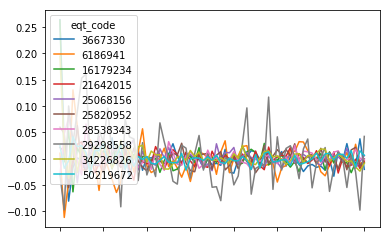

In [133]:
equity_mean.iloc[:10].T.plot()

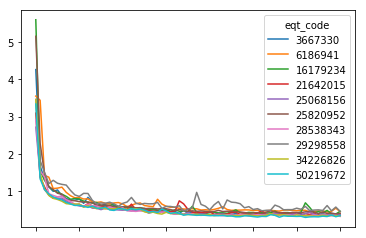

In [134]:
equity_std.iloc[:10].T.plot()

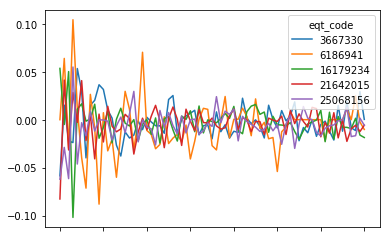

In [126]:
equity_median.iloc[:5].T.plot()

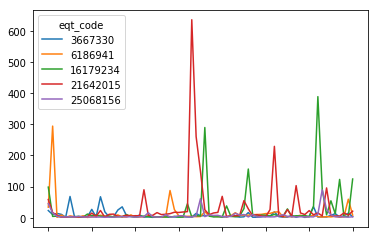

In [128]:
equity_kurtosis.iloc[:5].T.plot()

In [141]:
np.max(equity_kurtosis.iloc[:5].values)

635.4304930758027

In [ ]:
equity_mean = data_test.groupby(["eqt_code"])[data_test.columns[3:]].mean()
equity_std = data_train.groupby(["eqt_code"])[data_train.columns[3:]].std()
equity_skew = data_train.groupby(["eqt_code"])[data_train.columns[3:]].skew()
equity_median = data_train.groupby(["eqt_code"])[data_train.columns[3:]].median()
equity_kurtosis = data_train.groupby(["eqt_code"])[data_train.columns[3:]].apply(pd.DataFrame.kurtosis)